# Import Libraries

In [1]:
# Re-implement using pure shapely + rasterio (no geopandas) to avoid array-interface issues
import warnings
import sys
import geopandas as gpd
import re
import rasterio
from rasterio.warp import reproject, Resampling, transform_geom
from rasterio.features import rasterize
import fiona

from rasterstats import zonal_stats
from exactextract import exact_extract

import numpy as np
import pandas as pd
from pathlib import Path

import shutil
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
raw_fold_drive = "G"

if sys.platform == 'darwin':
    print('mac')
    raw_fold = Path('/users/ink/Google Drive/My Drive/')
else:
    print('pc')
    raw_fold = Path(f'{raw_fold_drive}:/My Drive/')

mac


In [3]:
pth = raw_fold / "OET_Milford"
dst_dir = raw_fold / "Milford_OpenET"
# make sure the destination directory exists
dst_dir.mkdir(parents=True, exist_ok=True)

DATA_DIR = dst_dir
OUT_DIR = dst_dir / "applied_water_out"
OUT_DIR.mkdir(parents=True, exist_ok=True)

mask_path = "oet_mask.gpkg"

# File discovery
et_keyword = "ensemble_et"
pr_keyword = "gridmet_pr"
month_re = re.compile(r"(?P<year>\d{4})[_\-](?P<month>\d{2})")

def month_key(p: Path):
    m = month_re.search(p.name)
    return f"{m.group('year')}-{m.group('month')}" if m else None

# Compile tif Files into a single Directory for Zonal Statistics

In [ ]:
for file in pth.rglob("*OpenET*ensemble_*.tif"):
    new_name = str(file.stem).split(" ")[-1] + file.suffix
    dst = dst_dir / new_name
    shutil.copy2(file, dst)  # preserves metadata like timestamps
    print(f"Copied {file} to {dst}")


# Calculate Consumptive Use

In [ ]:
et_files = {month_key(p): p for p in DATA_DIR.glob("*.tif") if et_keyword in p.name.lower() and month_key(p)}
pr_files = {month_key(p): p for p in DATA_DIR.glob("*.tif") if pr_keyword in p.name.lower() and month_key(p)}
months = sorted(set(et_files) & set(pr_files))
assert months, "No month overlap between ET and PR rasters found."

# Read AOI polygons
with fiona.open(mask_path) as vec:
    vec_crs = vec.crs_wkt or vec.crs
    geoms = [feat["geometry"] for feat in vec if feat.get("geometry")]
assert geoms, "No geometries found in AOI mask."

MM_TO_M = 1.0/1000.0
M3_PER_ACRE_FT = 1233.48184

def pixel_area_m2(transform, shape, crs):
    a = transform.a
    e = transform.e
    f = transform.f
    h, w = shape
    try:
        is_geo = crs.is_geographic
    except Exception:
        is_geo = True
    if not is_geo:
        return abs(a*e) * np.ones((h, w), dtype="float64")
    # geographic: vary with latitude
    rows = np.arange(h)
    lat = f + (rows + 0.5) * e
    lat_rad = np.deg2rad(lat)
    m_per_deg_lat = 111320.0
    m_per_deg_lon = 111320.0*np.cos(lat_rad)
    dlat_deg = abs(e)
    dlon_deg = abs(a)
    row_area = (m_per_deg_lat*dlat_deg) * (m_per_deg_lon*dlon_deg)
    return np.repeat(row_area[:, None], w, axis=1)

records = []

for key in months:
    try:
        et_path = et_files[key]
        pr_path = pr_files[key]
        print(f"Processing month {key}: ET={et_path.name}, PR={pr_path.name}")
        
        with rasterio.open(et_path) as et_ds:
            et = et_ds.read(1, masked=True).astype("float32")
            et_profile = et_ds.profile.copy()
            et_crs = et_ds.crs
            et_transform = et_ds.transform
            h, w = et.shape
            et_nodata = et_ds.nodata
            
            # Rasterize AOI to ET grid
            geoms_xf = [transform_geom(src_crs=vec_crs, dst_crs=et_crs.to_wkt() if hasattr(et_crs, "to_wkt") else et_crs, geom=g) for g in geoms]
            aoi_mask = rasterize(
                ((g, 1) for g in geoms_xf),
                out_shape=(h, w),
                transform=et_transform,
                fill=0,
                all_touched=False,
                dtype="uint8"
            ).astype(bool)
            
            # Reproject PR to ET grid
            with rasterio.open(pr_path) as pr_ds:
                pr = pr_ds.read(1, masked=True).astype("float32")
                dst = np.zeros((h, w), dtype="float32")
                
                reproject(
                    source=pr.filled(0.0),
                    destination=dst,
                    src_transform=pr_ds.transform,
                    src_crs=pr_ds.crs,
                    dst_transform=et_transform,
                    dst_crs=et_crs,
                    resampling=Resampling.bilinear,
                    src_nodata=pr_ds.nodata if pr_ds.nodata is not None else None,
                    dst_nodata=None,
                )
                # Validity for PR after reprojection
                valid_src = (~pr.mask).astype("uint8")
                valid_dst = np.zeros((h, w), dtype="uint8")
                reproject(
                    source=valid_src,
                    destination=valid_dst,
                    src_transform=pr_ds.transform,
                    src_crs=pr_ds.crs,
                    dst_transform=et_transform,
                    dst_crs=et_crs,
                    resampling=Resampling.nearest,
                )
                pr_on_et = np.ma.array(dst, mask=(valid_dst == 0))
            
            # AOI + validity masks
            et_valid = (~et.mask) & aoi_mask
            pr_valid = (~pr_on_et.mask) & aoi_mask
            
            # Combined validity
            valid = (~et.mask) & (~pr_on_et.mask) & aoi_mask
            
            # Applied ET [mm/month]
            applied = np.ma.array(np.zeros_like(et, dtype="float32"), mask=~valid)
            applied[valid] = et[et_valid] - pr_on_et[valid]*0.9
            applied[valid] = np.where(applied[valid] > 0, applied[valid], 0.0)
        
            # Write output raster
            out_raster = OUT_DIR / f"applied_et_{key.replace('-', '_')}.tif"
            out_profile = et_profile.copy()
            out_profile.update(dtype="float32", count=1, nodata=-9999.0, compress="lzw", tiled=True)
            with rasterio.open(out_raster, "w", **out_profile) as dst:
                dst.write(applied.filled(-9999.0).astype("float32"), 1)

            # Totals (mm to m, then * area)
            area = pixel_area_m2(et_transform, (h, w), et_crs)
            et_tot_m3 = float((et[et_valid] * MM_TO_M * area[et_valid]).sum())
            pr_tot_m3 = float((pr_on_et[pr_valid] * MM_TO_M * area[pr_valid]).sum())
            
            # Applied computed over pixels where BOTH valid within AOI
            both = et_valid & pr_valid
            applied_mm = np.maximum(et[both] - pr_on_et[both], 0.0)
            app_tot_m3 = float((applied_mm * MM_TO_M * area[both]).sum())
            
            records.append({
                "month": key,
                "et_acre_feet_masked": et_tot_m3 / M3_PER_ACRE_FT,
                "precip_acre_feet_masked": pr_tot_m3 / M3_PER_ACRE_FT,
                "applied_acre_feet_masked": app_tot_m3 / M3_PER_ACRE_FT,
                "et_pixels_in_aoi": int(et_valid.sum()),
                "pr_pixels_in_aoi": int(pr_valid.sum()),
                "both_valid_pixels": int(both.sum()),
                "et_file": et_path.name,
                "pr_file": pr_path.name,
            })

    except Exception as e:
        print(f"Error processing month {key}: {e}", file=sys.stderr)
        pass
df = pd.DataFrame.from_records(records).sort_values("month")
csv_path = OUT_DIR / "masked_et_pr_applied_acrefeet_summary.csv"
df.to_csv(csv_path, index=False)


In [ ]:
df['month'] = pd.to_datetime(df['month'])
adf = df.set_index(['month'])
adf = adf[adf.index.month.isin([4,5,6,7,8,9,10])]
yrdf = adf.groupby(adf.index.year).sum()
yrdf['applied_acre_feet_masked'].plot(marker='.')
plt.grid()
plt.ylabel('Consumptive Use of Applied Water (acre-feet)')
plt.savefig("consumptive_use_applied_et.pdf")
plt.savefig("consumptive_use_applied_et.png")

# Caculate Zonal Statistics

In [4]:
aoi_path = "gis_files/pou_oet.gpkg"
aois = gpd.read_file(aoi_path).to_crs(epsg=4326)
aois.columns

Index(['GROUP_NUMB', 'URL', 'ACRES', 'WRNUMS', 'dbURL', 'recordID', 'FieldNo',
       'WaterSourc', 'FARMNAME', 'qtywtr', 'accID', 'Acnt_no', 'field_id',
       'field_id_L', 'Shape_Leng', 'Shape_Area', 'match_id', 'geometry'],
      dtype='object')

In [18]:
# File discovery helpers
et_keyword = "ensemble_et"
pr_keyword = "gridmet_pr"
month_re = re.compile(r"(?P<year>\d{4})[_\-](?P<month>\d{2})")

def month_key(p: Path):
    m = month_re.search(p.name)
    return f"{m.group('year')}-{m.group('month')}" if m else None

# Collect rasters
et_files = {month_key(p): p for p in DATA_DIR.glob("*.tif") if (et_keyword in p.name.lower()) and month_key(p)}
pr_files = {month_key(p): p for p in DATA_DIR.glob("*.tif") if (pr_keyword in p.name.lower()) and month_key(p)}
applied_files = {month_key(p): p for p in OUT_DIR.glob("*.tif") if ("applied_et" in p.name.lower()) and month_key(p)}

months = sorted(set(et_files) & set(pr_files) & set(applied_files))
assert months, "No overlapping months found for rasters."


rows = []
zonal = {}
for key in months:
    year = int(key.split("-")[0])
    mo = int(key.split("-")[1])
    if year >= 1990 and mo in [4,5,6,7,8,9,10]:
        et_path = et_files[key]
        pr_path = pr_files[key]
        applied_path = applied_files[key]
        print(f"Processing month {key}: Consumed={applied_path.name},") #ET={et_path.name}, PR={pr_path.name}, ")
        
        pths = {"consumed":applied_path} #"et":et_path, "precip":pr_path, }
        for lab, pth in pths.items():
            try:
                #vals = zonal_stats(aois, pth, stats="mean", all_touched=True)
                incl = ['GROUP_NUMB', 'ACRES', 'recordID',
                        'WaterSourc']
                vals = exact_extract(pth, aois, ["mean"], include_cols=incl)
                results = [v['properties'] for v in vals]
                #zonal[f"{key}-{lab}"] = results
                zonal[f"{key}-{lab}"] = pd.DataFrame(results)
            except Exception as e:
                print(f"Error processing {key}, {lab}: {e}")
                pass



Processing month 1990-04: Consumed=applied_et_1990_04.tif,
Processing month 1990-05: Consumed=applied_et_1990_05.tif,
Processing month 1990-06: Consumed=applied_et_1990_06.tif,
Processing month 1990-07: Consumed=applied_et_1990_07.tif,
Processing month 1990-08: Consumed=applied_et_1990_08.tif,
Processing month 1990-09: Consumed=applied_et_1990_09.tif,
Processing month 1990-10: Consumed=applied_et_1990_10.tif,
Processing month 1991-04: Consumed=applied_et_1991_04.tif,
Processing month 1991-05: Consumed=applied_et_1991_05.tif,
Processing month 1991-06: Consumed=applied_et_1991_06.tif,
Processing month 1991-07: Consumed=applied_et_1991_07.tif,
Processing month 1991-08: Consumed=applied_et_1991_08.tif,
Processing month 1991-09: Consumed=applied_et_1991_09.tif,
Processing month 1991-10: Consumed=applied_et_1991_10.tif,
Processing month 1992-04: Consumed=applied_et_1992_04.tif,
Processing month 1992-05: Consumed=applied_et_1992_05.tif,
Processing month 1992-06: Consumed=applied_et_1992_06.ti

In [36]:
modata = modata = pd.concat(zonal).reset_index()
modata['month'] = modata['level_0'].str.split('-').str[0] + '-' + modata['level_0'].str.split('-').str[1]
modata['variable'] = modata['level_0'].str.split('-').str[2]
modata['month'] = pd.to_datetime(modata['month'])
modata['year'] = modata['month'].dt.year
modata['consumed'] = modata['mean'] * 0.00328084 * modata['ACRES']
modata = modata.rename(columns={'level_1':'oid'})
modata = modata.groupby(['oid','year']).sum(numeric_only=True)['consumed']#.stack()
#modata['consumed'] = modata['mean'] * 0.00328084 
modata = modata.unstack(level=1)
##
#modata = 0.00328084 * modata * modata.index.get_level_values(-1).map(aois['ACRES'].to_dict())
modata.columns = [f"consumed_{col}" for col in modata.columns]


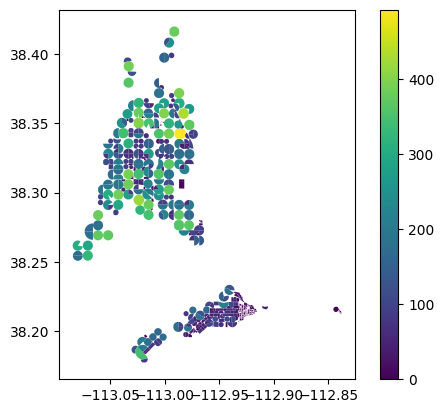

In [38]:
aoi_path = "gis_files/pou_oet.gpkg"
aois = gpd.read_file(aoi_path).to_crs(epsg=4326)
app_gis = pd.merge(aois, modata, left_index=True, right_index=True)
app_gis.plot(column='consumed_2024',legend=True)
app_gis.to_file("gis_files/pou_oet_consumed_1991_2025.gpkg")


In [39]:
gdf = gpd.read_file("gis_files/pou_oet_applied_et_1991_2025.gpkg")
ws = gdf.groupby(['GROUP_NUMB']).WaterSourc.first().to_dict()
gdf = gdf.groupby('GROUP_NUMB').sum(numeric_only=True)
gdf['WaterSourc'] = gdf.index.map(ws)
gdf = gdf.rename(columns=lambda x: x.replace('applied_','efet_'))


ndvi = gpd.read_file("gis_files/pou_classified.gpkg")
ndvi.columns
ndvi = ndvi.groupby('GROUP_NUMB').agg({
                                'FARMNAME':'first',
                                'type':'first',
                                'peak_ndvi':'max',
                                'median_ndvi':'median',
                                'peak_date':'max',
                                'num_cuts':'max',
                                'pump_hrs':'mean',
                                'early_med':'median',
                                'late_med':'median'
                                }).round(2)
ndvi['watering_days'] = ndvi['pump_hrs'] / 24.0
ndvi = ndvi.drop(columns=['pump_hrs'])

fields = pd.merge(gdf, ndvi, left_index=True, right_index=True).round(2)
fields.to_csv("output_tables/fields_by_groupnumber_v2.csv")

In [ ]:
import pandas as pd
fields = pd.read_csv("output_tables/fields_by_groupnumber_v2.csv")
fields.columns
fields['pump_est_2024'] = fields['efet_2024']/0.70


well = pd.read_csv("output_tables/wells_with_properties.csv")
well = well[well['USES']=='I']
wells_w_field_info = pd.merge(well, fields, left_on='GROUP_NUMB', right_on='GROUP_NUMB')
wells_w_field_info.sort_values("GROUP_NUMB")
nowellsperfield = wells_w_field_info.groupby('GROUP_NUMB').size().to_dict()
wells_w_field_info['num_wells_per_field'] = wells_w_field_info['GROUP_NUMB'].map(nowellsperfield)
wells_w_field_info.drop(columns=['qtywtr',
                                 'AbandonDate',
                                 'proof_flow_gpm',
                                 'NewWellDate',],inplace=True)
wells_w_field_info.to_clipboard()